# 사전설정

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

## 종목 설정

In [2]:
attack_tickers = {
        'KODEX 레버리지': '122630.KS',
        'TIGER 나스닥100': '133690.KS',
        'TIGER 2차전지': '364980.KS'
}
safe_ticker = {'KODEX 국고채3년': '114260.KS'}
all_tickers = {**attack_tickers, **safe_ticker}

# 데이터 로드

In [3]:
# 모멘텀 계산을 위해 백테스트 시작 기간보다 넉넉하게 데이터 로드
start_date = '2023-06-01'
end_date = '2024-12-31'
backtest_start_date = '2024-01-01'
initial_capital = 100000000
momentum_window_months = 6

In [5]:
try:
    # 데이터 다운로드
    raw_data = yf.download(list(all_tickers.values()), start=start_date, end=end_date, progress=False, auto_adjust=False)
    
    # Close 가격 추출 (Adj Close가 없으므로 Close 사용)
    data = raw_data['Close'].copy()
    
    # 컬럼명을 티커명으로 변경
    data.columns = all_tickers.keys()
    
    if data.isnull().values.any():
        print("데이터에 누락된 값이 있어 채워넣습니다.")
        data.fillna(method='ffill', inplace=True)
    
    print("데이터 다운로드 성공!")
    print(f"데이터 형태: {data.shape}")
    print(f"\n최근 5행:\n{data.tail()}")
    
except Exception as e:
    print(f"데이터 다운로드 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

데이터 다운로드 성공!
데이터 형태: (370, 4)

최근 5행:
            KODEX 레버리지  TIGER 나스닥100  TIGER 2차전지  KODEX 국고채3년
Date                                                         
2024-12-23     61685.0       14230.0    138730.0       8670.0
2024-12-24     61625.0       14230.0    139330.0       8555.0
2024-12-26     61635.0       14080.0    142490.0       8380.0
2024-12-27     61635.0       13995.0    141825.0       8375.0
2024-12-30     61655.0       13915.0    140880.0       8385.0


# 백테스트 수행

## 전략 검증 포인트
- ✅ **투자 유니버스**: 공격자산 3종 + 안전자산 1종
- ✅ **상대 모멘텀**: 공격자산(레버리지, 나스닥100, 2차전지) 중 6개월 수익률 1위 선정
- ✅ **절대 모멘텀**: 1위 자산 수익률 > 안전자산(국고채3년) 수익률 비교
- ✅ **투자 방식**: 선정된 단일 자산에 100% 집중 투자
- ✅ **리밸런싱**: 매월 마지막 거래일 장 마감 후
- ✅ **적용 시점**: 리밸런싱 다음 영업일부터 새로운 자산 보유

In [ ]:
# 백테스트 시뮬레이션
backtest_data = data.loc[backtest_start_date:]
monthly_data = data.resample('M').last()

portfolio_history = pd.Series(index=backtest_data.index, dtype=float)
portfolio_value = initial_capital
position = None

rebalance_dates = monthly_data.loc[backtest_start_date:].index

for i in range(len(rebalance_dates)):
    current_rebal_date = rebalance_dates[i]
        
    # 모멘텀 계산: 리밸런싱 시점 기준 6개월 전 대비 수익률
    momentum_start_date = current_rebal_date - pd.DateOffset(months=momentum_window_months)
    hist_prices_start = monthly_data.loc[:momentum_start_date].iloc[-1]
    hist_prices_end = monthly_data.loc[current_rebal_date]

    momentum = (hist_prices_end / hist_prices_start) - 1

    print(f"\n[{current_rebal_date.strftime('%Y-%m-%d')}] 리밸런싱 (장 마감 후)")
    print(f"6개월 모멘텀(%): {(momentum * 100).round(2).to_dict()}")

    # 1단계: 상대 모멘텀 - 공격자산 중 최고 수익률 자산 선정
    attack_momentum = momentum[attack_tickers.keys()]
    relative_momentum_winner = attack_momentum.idxmax()
    winner_momentum = momentum[relative_momentum_winner]
    
    print(f"상대 모멘텀 1위: {relative_momentum_winner} ({winner_momentum*100:.2f}%)")
    
    # 2단계: 절대 모멘텀 - 1위 자산 vs 안전자산 비교
    safe_ticker_name = list(safe_ticker.keys())[0]
    safe_momentum = momentum[safe_ticker_name]
    
    print(f"안전자산 모멘텀: {safe_ticker_name} ({safe_momentum*100:.2f}%)")
    
    if winner_momentum > safe_momentum:
        position = relative_momentum_winner
        print(f"✅ 최종 선택: {position} (공격자산 - 상승장)")
    else:
        position = safe_ticker_name
        print(f"🛡️ 최종 선택: {position} (안전자산 - 하락장 방어)")
    
    # 리밸런싱 적용 기간 설정 (다음 영업일부터)
    start_period = current_rebal_date + pd.Timedelta(days=1)
    
    if i < len(rebalance_dates) - 1:
        end_period = rebalance_dates[i+1]
    else:
        end_period = backtest_data.index[-1]
    
    # 실제 거래일만 필터링
    period_data = backtest_data.loc[start_period:end_period]
    
    if len(period_data) == 0:
        print(f"  ⚠ 적용 기간 데이터 없음")
        continue
    
    # 이전 기간의 포트폴리오 가치 사용
    if i == 0:
        temp_value = initial_capital
    else:
        # 가장 최근 포트폴리오 가치 찾기
        available_dates = portfolio_history.dropna().index
        if len(available_dates) > 0:
            last_date = available_dates[-1]
            temp_value = portfolio_history.loc[last_date]
        else:
            temp_value = initial_capital
    
    # 선택된 자산 100% 집중 투자
    selected_asset_prices = period_data[position]
    
    # 매수 주식 수 계산 (첫 거래일 종가로 매수)
    shares = temp_value / selected_asset_prices.iloc[0]
    
    # 일별 포트폴리오 가치 계산
    portfolio_daily_value = selected_asset_prices * shares
    
    # 포트폴리오 히스토리에 저장
    portfolio_history.loc[period_data.index] = portfolio_daily_value
    
    print(f"  → 적용 기간: {period_data.index[0].strftime('%Y-%m-%d')} ~ {period_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"  → 리밸런싱 기준 평가액: {temp_value:,.0f}원")
    print(f"  → 기간 종료 평가액: {portfolio_daily_value.iloc[-1]:,.0f}원")
    print(f"  → 기간 수익률: {(portfolio_daily_value.iloc[-1]/temp_value - 1)*100:+.2f}%")



[2024-01-31] 리밸런싱
모멘텀 (6개월): {'KODEX 레버리지': 2.81, 'TIGER 나스닥100': -6.02, 'TIGER 2차전지': 16.58, 'KODEX 국고채3년': -42.43}
선택: TIGER 2차전지 (공격자산)
  적용 기간: 2024-02-01 ~ 2024-02-29
  기간 시작 가치: 100,000,000원
  기간 종료 가치: 104,007,054원
  기간 수익률: +4.01%

[2024-02-29] 리밸런싱
모멘텀 (6개월): {'KODEX 레버리지': 2.71, 'TIGER 나스닥100': 4.64, 'TIGER 2차전지': 19.89, 'KODEX 국고채3년': -36.17}
선택: TIGER 2차전지 (공격자산)
  적용 기간: 2024-03-04 ~ 2024-03-29
  기간 시작 가치: 104,007,054원
  기간 종료 가치: 105,384,124원
  기간 수익률: +1.32%

[2024-03-31] 리밸런싱
모멘텀 (6개월): {'KODEX 레버리지': 3.28, 'TIGER 나스닥100': 29.43, 'TIGER 2차전지': 25.14, 'KODEX 국고채3년': -11.38}
선택: TIGER 나스닥100 (공격자산)
  적용 기간: 2024-04-01 ~ 2024-04-30
  기간 시작 가치: 105,384,124원
  기간 종료 가치: 99,344,323원
  기간 수익률: -5.73%

[2024-04-30] 리밸런싱
모멘텀 (6개월): {'KODEX 레버리지': 2.9, 'TIGER 나스닥100': 22.19, 'TIGER 2차전지': 24.26, 'KODEX 국고채3년': -18.59}
선택: TIGER 2차전지 (공격자산)
  적용 기간: 2024-05-02 ~ 2024-05-31
  기간 시작 가치: 99,344,323원
  기간 종료 가치: 106,054,014원
  기간 수익률: +6.75%

[2024-05-31] 리밸런싱
모멘텀 (6개월): {'KODEX 레버리지

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29992\1792737273.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').last()


# 성과분석

In [8]:
# 4. 성과 분석
portfolio_df = portfolio_history.dropna().to_frame('Portfolio')
portfolio_df['Daily_Return'] = portfolio_df['Portfolio'].pct_change()

final_value = portfolio_df['Portfolio'].iloc[-1]
cagr = ((final_value / initial_capital) ** (365.0 / len(portfolio_df))) - 1

rolling_max = portfolio_df['Portfolio'].cummax()
daily_drawdown = portfolio_df['Portfolio'] / rolling_max - 1.0
mdd = daily_drawdown.min()
    
sharpe_ratio = portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() * np.sqrt(252)

print(f"초기 자산: {initial_capital:,.0f} 원")
print(f"최종 자산: {final_value:,.0f} 원")
print(f"CAGR (연율화 수익률): {cagr:.2%}")
print(f"MDD (최대 낙폭): {mdd:.2%}")
print(f"Sharpe Ratio (샤프 지수): {sharpe_ratio:.2f}\n")

초기 자산: 100,000,000 원
최종 자산: 118,063,440 원
CAGR (연율화 수익률): 31.88%
MDD (최대 낙폭): -29.45%
Sharpe Ratio (샤프 지수): 0.81



# 성과 시각화

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager, rc

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

## 1. 포트폴리오 가치 추이

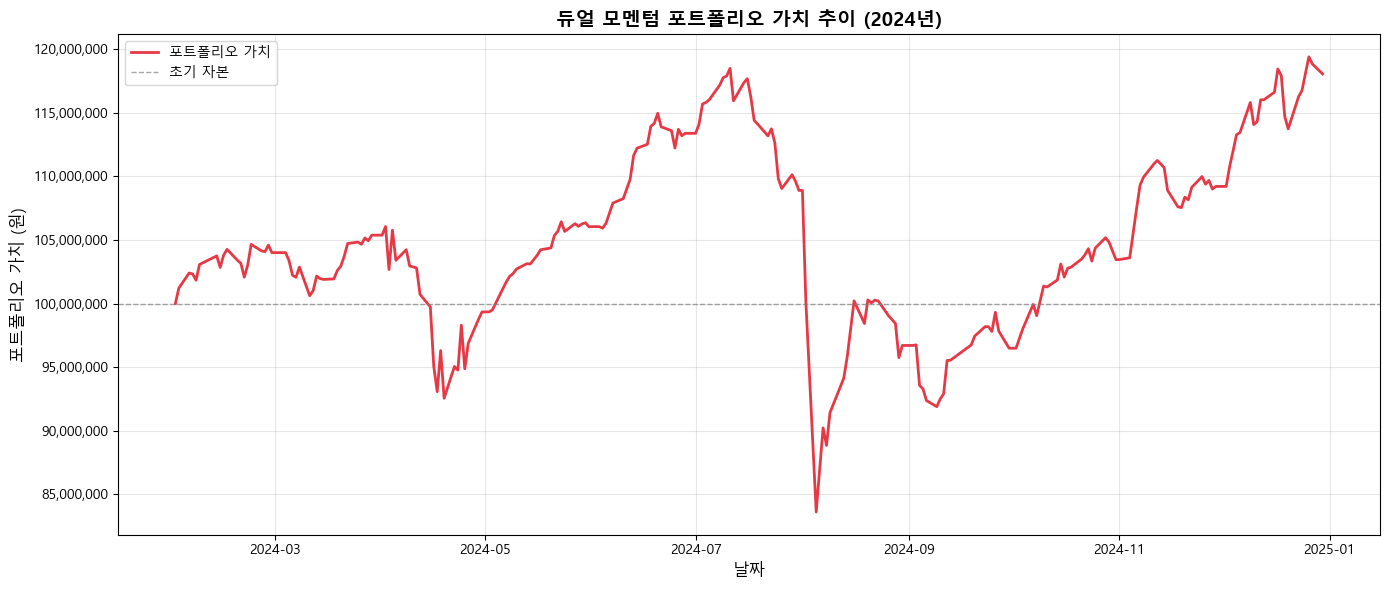

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, portfolio_df['Portfolio'], linewidth=2, color='#E63946', label='포트폴리오 가치')
ax.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='초기 자본')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('포트폴리오 가치 (원)', fontsize=12)
ax.set_title('듀얼 모멘텀 포트폴리오 가치 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 금액 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

## 2. 누적 수익률 추이

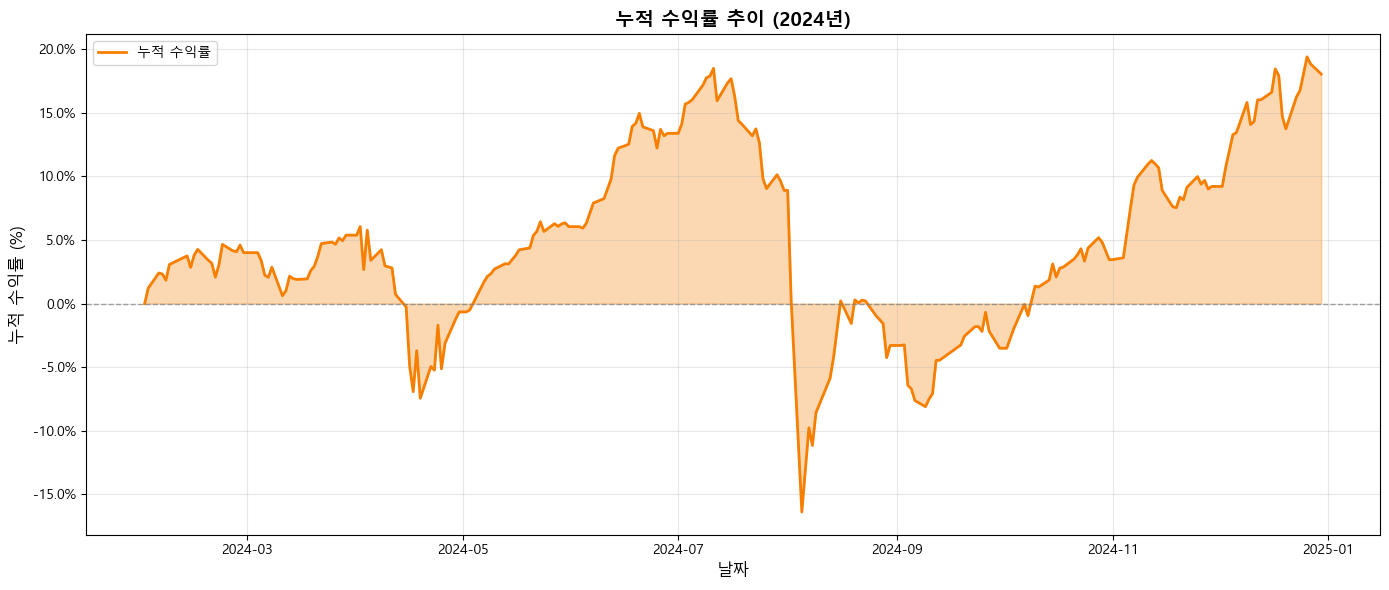

In [11]:
cumulative_returns = (portfolio_df['Portfolio'] / initial_capital - 1) * 100

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, cumulative_returns, linewidth=2, color='#F77F00', label='누적 수익률')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.fill_between(portfolio_df.index, 0, cumulative_returns, alpha=0.3, color='#F77F00')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('누적 수익률 (%)', fontsize=12)
ax.set_title('누적 수익률 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 퍼센트 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

## 3. 낙폭(Drawdown) 분석

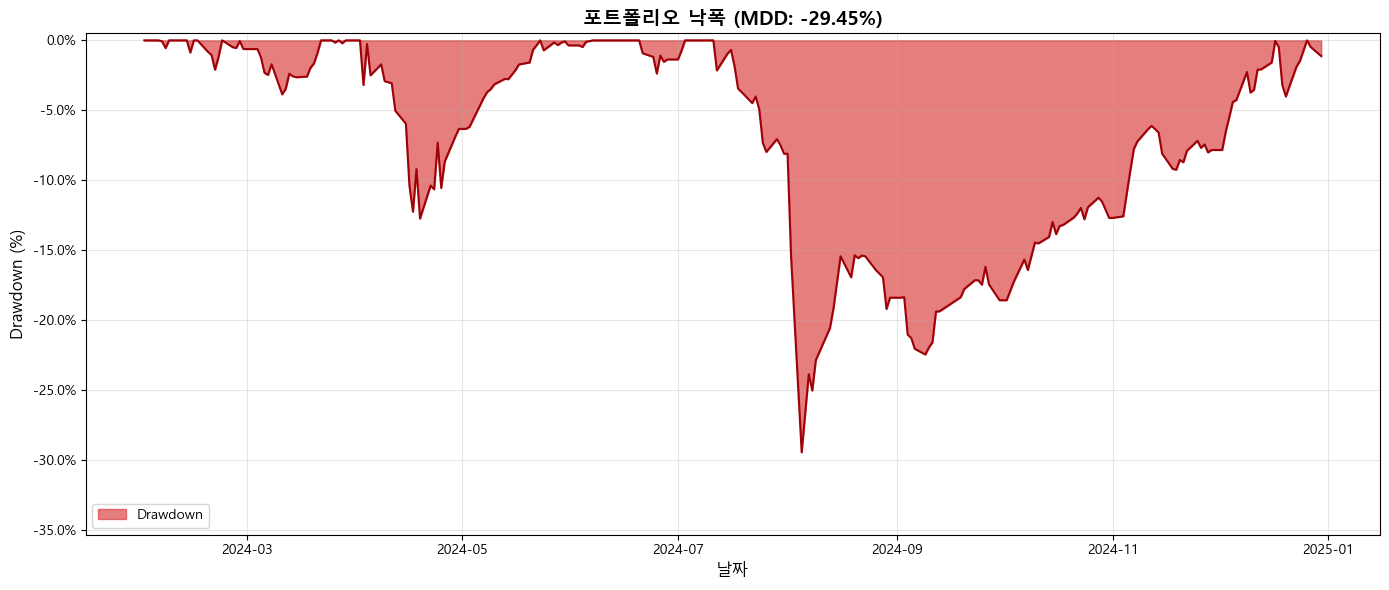

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100
ax.fill_between(portfolio_df.index, 0, drawdown_pct, color='#D62828', alpha=0.6, label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=1.5, color='#9D0208')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_title(f'포트폴리오 낙폭 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# y축 범위 설정
y_min = min(drawdown_pct.min() * 1.2, -1)
ax.set_ylim(y_min, 0)

# 퍼센트 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

## 4. 일별 수익률 분포

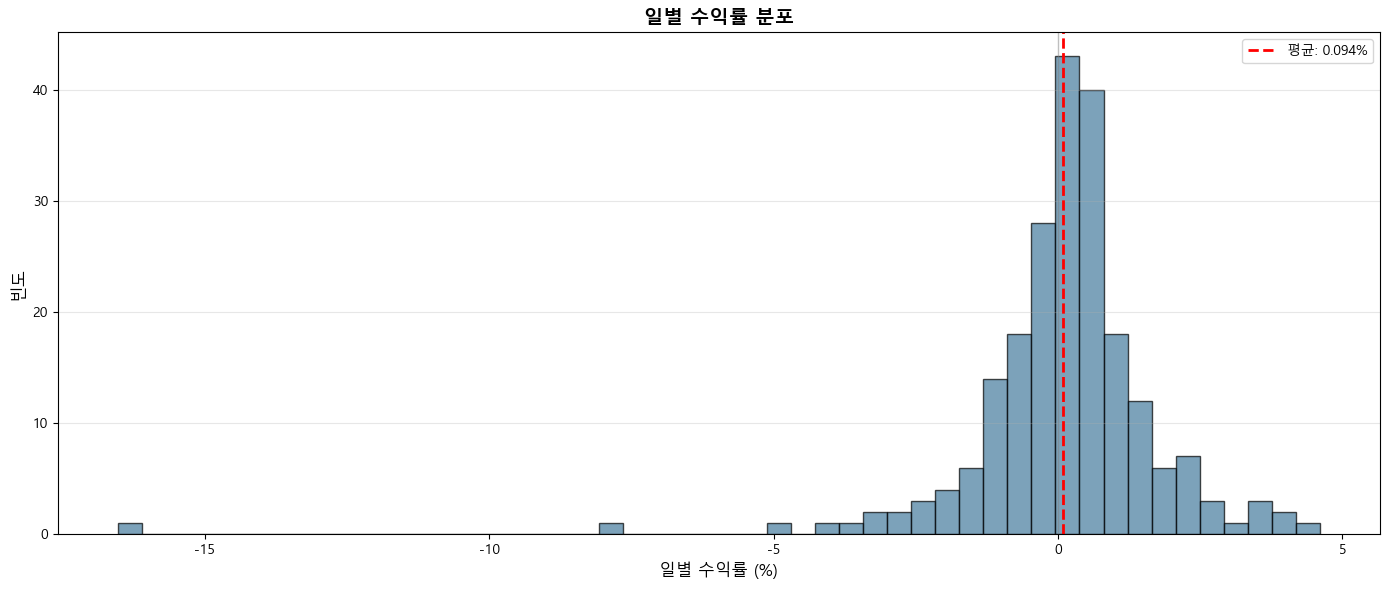

일별 수익률 통계:
  평균: 0.0939%
  표준편차: 1.8377%
  최대: 4.6047%
  최소: -16.5296%


In [13]:
daily_returns_pct = portfolio_df['Daily_Return'].dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

ax.hist(daily_returns_pct, bins=50, color='#457B9D', alpha=0.7, edgecolor='black')
ax.axvline(daily_returns_pct.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {daily_returns_pct.mean():.3f}%')
ax.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('일별 수익률 (%)', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_title('일별 수익률 분포', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"일별 수익률 통계:")
print(f"  평균: {daily_returns_pct.mean():.4f}%")
print(f"  표준편차: {daily_returns_pct.std():.4f}%")
print(f"  최대: {daily_returns_pct.max():.4f}%")
print(f"  최소: {daily_returns_pct.min():.4f}%")

## 5. 월별 수익률

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29992\3062344622.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100


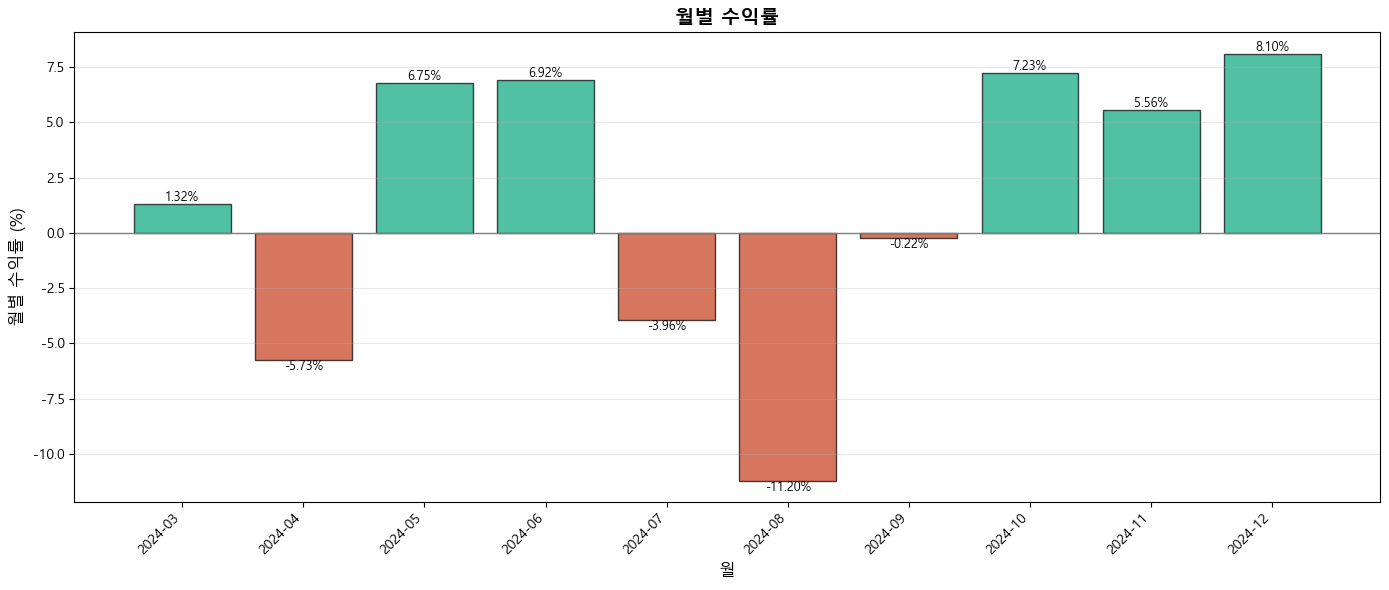

In [14]:
# 월별 수익률 계산
monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#06A77D' if x >= 0 else '#C73E1D' for x in monthly_returns]
bars = ax.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('월별 수익률 (%)', fontsize=12)
ax.set_title('월별 수익률', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

# x축 레이블 설정
months = [date.strftime('%Y-%m') for date in monthly_returns.index]
ax.set_xticks(range(len(monthly_returns)))
ax.set_xticklabels(months, rotation=45, ha='right')

# 막대 위에 값 표시
for i, (bar, val) in enumerate(zip(bars, monthly_returns)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()